基于神经网络的语音情感识别代码


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tflearn
import scipy.io as sio
#import pickle
import matplotlib.pyplot as plt
#import numpy as np
#import matplotlib.mlab as mlab 

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


导入输入数据
通过pd.read_csv读出的是dataframe格式

In [2]:
sample = pd.read_csv('pcasample1080-95.txt', header = None )

In [12]:
sample[:4]

,0
0,-0.338708092\t1.828532911\t1.309321057\t0.1748...
1,1.648187427\t0.1857881\t-0.836151066\t1.268811...
2,-0.130687255\t0.550807496\t1.863070511\t0.8477...
3,1.821510998\t0.938574551\t-0.035359077\t0.4838...


In [3]:
data = sio.loadmat('pythonsample1080.mat')

In [4]:
#未经过PCA的特征
angry = data['angry']  # 5
happy = data['happy']  # 1
sad = data['sad'] # 4
neutral = data['neutral'] # 0
surprise = data['surprise'] # 2
fear = data['fear'] # 3
part = data['part']
label = data['pythonlabel']
train_x = np.concatenate((angry,happy,sad,neutral,surprise,fear),axis=0)
test_x = part

In [4]:
#经过特征降维的特征矩阵，与上代码块并立
angry = data['angrypca']  # 5
happy = data['happypca']  # 1
sad = data['sadpca'] # 4
neutral = data['neutralpca'] # 0
surprise = data['surprisepca'] # 2
fear = data['fearpca'] # 3
part = data['partpca']
label = data['pythonlabel']
train_x = np.concatenate((angry,happy,sad,neutral,surprise,fear),axis=0)
test_x = part

In [70]:
happy[0]
label.shape

(1200, 1)

对标签进行独热编码处理

In [5]:
def one_hot_encode(x):

    '''x : 样本的标签值
       返回编码的矩阵'''
    #创建编码器
    encode = np.zeros((len(x), 6))
    for n in range(len(x)):
        encode[n][x[n]] = 1.
    
    return encode

label_one_hot = one_hot_encode(label)

In [6]:
label_one_hot.shape
print(label[0])
label_one_hot[0]

[5]


array([ 0.,  0.,  0.,  0.,  0.,  1.])

In [7]:
train_y, test_y = label_one_hot[0:1080, :], label_one_hot[1080:, :]

In [8]:
train_y.shape
test_y.shape

(120, 6)

构建神经网络

In [12]:
def build_model():
    # This resets all parameters and variables, leave this here
    tf.reset_default_graph()
    
    # Inputs
    net = tflearn.input_data([None, train_x.shape[1]]) 

    # Hidden layer(s)
    net = tflearn.fully_connected(net, 600, activation='ReLU')
    net = tflearn.fully_connected(net, 32, activation='ReLU')
    #net = tflearn.fully_connected(net, 50, activation='ReLU')
    
    # Output layer and training model
    net = tflearn.fully_connected(net, 6, activation='softmax')
    net = tflearn.regression(net, optimizer='sgd', learning_rate=0.001, loss='categorical_crossentropy')
    
    model = tflearn.DNN(net, tensorboard_verbose=1, tensorboard_dir="logs")
    return model


In [13]:
# Build the model
model = build_model()  

In [14]:
# Training 
model.fit(train_x, train_y, validation_set=0.1, show_metric=True, batch_size=20, n_epoch=3000)


Training Step: 146999  | total loss: 0.02074 | time: 1.288s
| SGD | epoch: 3000 | loss: 0.02074 - acc: 1.0000 -- iter: 960/972
Training Step: 147000  | total loss: 0.01986 | time: 2.309s
| SGD | epoch: 3000 | loss: 0.01986 - acc: 1.0000 | val_loss: 0.79164 - val_acc: 0.7500 -- iter: 972/972
--


In [16]:
$ tensorboard --logdir='/tmp/tflearn_logs'

NameError: name 'main' is not defined

In [21]:
$ tensorboard --logdir= /logs

SyntaxError: invalid syntax (<ipython-input-21-6dfdb5a2acef>, line 1)

In [15]:
# Find the indices of the most confident prediction for each item. That tells us the predicted digit for that sample.
predictions = np.array(model.predict(test_x)).argmax(axis=1)

# Calculate the accuracy, which is the percentage of times the predicated labels matched the actual labels
actual = test_y.argmax(axis=1)
test_accuracy = np.mean(predictions == actual, axis=0)

# Print out the result
print("Test accuracy: ", test_accuracy)

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.
Test accuracy:  0.741666666667


In [35]:
prediction = model.predict(test_x)

In [44]:
test_y[5]

array([ 0.,  0.,  0.,  0.,  0.,  1.])

显示测试样本结果

In [52]:
 def display_result(pred_values, actual):
        pred_names = ['neutral', 'happy', 'surprised', 'fear', 'sad', 'angry']
        
        fig, axies = plt.subplots(nrows=1, ncols=1)
        ind = actual.argmax()
        fig.suptitle(pred_names[ind], fontsize=20, y=1.1)
        fig.tight_layout()
        n_predictions = 6
        margin = 0.05
        ind = np.arange(n_predictions)
        width = (1. - 2. * margin)/1.5
        
        a = axies.barh(ind + margin, pred_values[::-1], width)
        axies.set_yticks(ind + margin)
        axies.set_yticklabels(pred_names[::-1])
        axies.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        for rect in a:
            width = rect.get_width()
            plt.text(1.03*width, rect.get_y()+rect.get_height()/2.-0.1, '%.4f' % float(width))
        plt.show()        

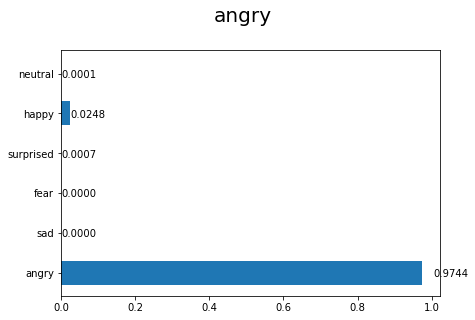

In [53]:
display_result(prediction[5], test_y[5])

模型名：model       1
学习率：  0.001   0.001   0.001   0.001   0.001
迭代次数：2000    2000    1000    1000    1000
第一层：  300     600     900     1200   1200     
第二层：  32      32      32     32     300
样本准确率： 0.7091 0.6955  0.6038   0.5405  0.6998
val准确率：  0.3704  0.4259   0.4444  0.4074   0.3796
测试准确率： 0.3916  0.4   0.408   0.3833  0.3416

In [ ]:
模型名：model       2
学习率：    0.001   0.001   0.001
迭代次数：  2000    1000    1000
第一层：     900    900     900     
第二层：     32     100     200
样本准确率  0.6914   0.6863  0.66  
val准确率： 0.4444  0.4907  0.4907
测试准确率:  0.408  0.4167  0.35

In [ ]:
模型名：model       3
学习率：    0.001   0.001   0.001    0.001
迭代次数：  2000    3000    3000     2000
第一层：     900    900      900     900   
第二层：     100     100     50      32
样本准确率   0.7850  0.7888  0.7715  0.6914
val准确率：  0.4167  0.4352  0.3796  0.3981
测试准确率:  0.433   0.4167  0.4583  0.45

In [ ]:
经过特征降维的训练结果
模型名：model       4
学习率：    0.001   0.001   0.001      0.001      0.001
迭代次数：  2000    2000    2000       2000       2000
第一层：     300    600     900        600        600
第二层：     32     32      32         50         100
样本准确率  0.9594  0.9921  0.9890     0.9897     0.9940
val准确率： 0.7315  0.7407  0.7315     0.7963     0.7315
测试准确率: 0.725   0.75    0.73       0.7333     0.7483